# Part 2

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
def generate_data(m,n,winnow=False):
    if winnow:
        data = np.random.randint(2, size=(m,(n+1)))
        data = np.sign(data)
    else:
        data = np.random.uniform(low=-1, high=1, size=(m,(n+1)))
        data = np.sign(data)
    x = data
    y = data[:,0]
    return x,y

def generate_data_winnow(m,n):
    data = np.random.randint(2, size=(m,(n+1)))
    data = np.sign(data)
    return data

def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

## Binary Perceptron

In [3]:
# Binary perceptron algorithm 
# Learning rate? 
def perceptron_train(x,y,max_epoch=20, tol=0.01, learning_rate=1,random_select=False):
    m_train = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    x = add_bias(x)
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m_train)
    W = np.zeros(n+1)
    
    num_errors = 0 
    
    if random_select:
        max_epoch =1
        m = np.random.randint(low=0, high=m_train) #select random number of times to train the perceptron. 
    else:
        m = m_train
        
    for epoch in range(max_epoch):
        #print('epoch=',epoch)
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            pred_t = np.sign(W@x_t) #0 to begin with 
    
            if pred_t*y_t<=0:
                #print('t=',t)
                #print('error! y_lab=', y_t)
                num_errors +=1
                W = W + learning_rate*x_t.T*y_t
                errors[t] = num_errors 
                #print('W=',W)
                
        error_per_epoch[epoch] = num_errors
        #print(epoch, 'error=',errors[-1])
        
        #print('current_error_rate', error_per_epoch)
        
        if epoch>1:
            #print('old_error=',error_per_epoch[epoch-1])
            #print('new_error=',error_per_epoch[epoch])
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
 
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                print('error rate< 10%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')
                    break
        
    return W, error_per_epoch[:epoch+1]


def perceptron_test(x_test,y_test,W):
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    pred = np.sign(x_test@W) #(n,1) x (m_test,n)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])   
    return mistakes,pred

In [4]:
x,y = generate_data(20,30)
W, error_per_epoch = perceptron_train(x,y,max_epoch=30, tol=0.01, learning_rate=1)

error rate< 10%
no error


In [5]:
mistakes,pred = perceptron_test(x[:10],y[:10],W)

In [6]:
error_per_epoch
### Does not seem to converge for some combination of x and y. 

array([8., 3., 2., 0.])

## Winnow

In [42]:
def winnow_train(x,y,max_epoch=20,tol=0.01, learning_rate=1):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    W = np.ones(n)
    #x = add_bias(x)
    gamma_bound = n/2
    mistake_bound = (n/gamma_bound)**2
    #print(mistake_bound)
    num_errors = 0 
    
    #for epoch in range(max_epoch):
    epoch = 0
    while epoch < max_epoch:   
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
        #print('epoch=',epoch)
        #iterate through training set
        for t in range(m):
            
            x_t = x[t,:]
            y_t = y[t]
            gamma = W@x_t
            
            if gamma>= gamma_bound:
                pred_t = 1
            else:
                pred_t = 0
            
            if pred_t != y_t:
#                 print('error!')
                #print('pred=',pred_t)
#                 print('y_t=',y_t)
                num_errors+=1
                #print('x_t=',x_t)
                #print('y_t=',y_t)
                power = (y_t - pred_t)*x_t/1.0 #1 when error made on positive class, -1 when error made on negative class
                #print('ratio of update of W',power)
                W = W*(2**power) #element wise multiplication, and element wise power
                #print('W=',W)
                #Once weight>n, it should no longer change. 
                W[W>n] = n
#                 print(W)
                errors[t] = num_errors
#                 print('current error',num_errors)
                #print('W=',W)
                
        error_per_epoch[epoch] = num_errors
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            #print("Error rate is now ", error_per_epoch[epoch]/m )
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                #print('error rate< 5%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')  
                    break
        epoch += 1
    return W, error_per_epoch[:epoch+1]


def winnow_test(x_test,y_test,W):
    m_test = x_test.shape[0]
    n = x_test.shape[1]
    gamma = x_test@W
    pred = np.zeros(m_test)
    pred[gamma>=n/2] = 1
    diff = pred - y_test
    print(diff)
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

In [43]:
x,y = generate_data(40,20,winnow=True)
W, error_per_epoch = winnow_train(x,y,max_epoch=15,tol=0.01, learning_rate=1)
mistakes,pred = winnow_test(x[:20],y[:20],W)
mistakes

no error
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0

In [9]:
# Least Squares Regression

In [51]:
def compute_primal(X, Y):
    """
    Computes vector omega, which is called the primal form of the linear regression.
    :param X: the feature map vector
    :param Y: the target values of the data points
    :return: the vector omega
    """
    omega = np.linalg.pinv(X.T @ X) @ X.T @ Y
    return omega

def linear_predict(X_test, y_test, omega):
    f = X_test @ omega
    pred = np.where(f < 0, -1, 1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    return mistakes, pred

x,y = generate_data(40,20)
W = compute_primal(x,y)
mistakes,pred = linear_predict(x[:10], y[:10], W)
mistakes

0

In [11]:
# 1 Nearest Neighbors

In [73]:
def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def knn_test(x_test, y_test, x_train, y_train):
    distances = pairwise_distance_double(x_test, x_train)
    pred = np.zeros(x_test.shape[0])
    if x_test.shape[0] == 1:
        return 0, y_train
    
    sorted_distances = np.argsort(distances)[:,:1]
    pred = y_train[sorted_distances].flatten()
#     for i in range(x_test.shape[0]):
#         sorted_distances = np.argsort(distances[i])
#         nearest_j = sorted_distances[0]
#         pred[i] = y_train[nearest_j]

    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    
    return mistakes,pred

In [74]:
x,y = generate_data(40,20,winnow=False)
mistakes,pred = knn_test(x[:20], y[:20], x, y)
mistakes

0

## Estimate Sample Complexity

Justifying the choice of sample size: when n < log_2(1000), there is a possbility that the sample contains all possible combinations of n agents' outcomes. Igore this 

In [22]:
#Compute by brute force, the sample complexity of each training algorithms
#Might derive a lower bound for m for a fixed n. Refer to lecture notes. 

def calculate_gen_error(m, n, x_test, y_test, function_choice):
    x,y = generate_data(m,n,function_choice=='winnow')
    if function_choice=='winnow':
        W, _ = winnow_train(x,y,max_epoch=1,tol=0.01, learning_rate=1)
        test_mistakes,_ = winnow_test(x_test,y_test,W)
    elif function_choice == 'perceptron':
        W, _ = perceptron_train(x,y,max_epoch=1, tol=0.01, learning_rate=1,random_select=True)
        test_mistakes,_= perceptron_test(x_test,y_test,W)
    elif function_choice == 'linear':
        W = compute_primal(x,y)
        test_mistakes,_ = linear_predict(x_test, y_test, W)
    elif function_choice == '1nn':
        test_mistakes,_ = knn_test(x_test, y_test, x, y)
    return (1.0/ y_test.shape[0]) * test_mistakes

def estimate_sample_complexity(max_m,max_n,function_choice):
    number_of_runs = 20
    sample_complexity = np.zeros((max_n, number_of_runs))
    iterations_per_n = np.zeros(max_n)
    for n in np.arange(1,max_n):
        #research for a better test size, curse of dimensionality
        test_size = 2**n
        test_size = test_size if test_size > 0 and test_size < 10000 else 10000
        print("Now n=", n, "............", end='\r')
        
        #Repeat for number_of_runs runs. 
        for run in range(number_of_runs):
            x_test,y_test = generate_data(test_size,n,function_choice=='winnow')
            
            # These are our "pivotal" elements. We start by examining the (1,n) interval and then we will refine it
            m_left = 1
            error_left = calculate_gen_error(m_left, n, x_test, y_test, function_choice)
            m_right = n
            error_right = calculate_gen_error(m_right, n, x_test, y_test, function_choice)
            
            min_m_per_run = n
            min_error_per_run = 1
            m_current = n
            iterations = 1
            
            while True:
                # Try the mean to see what kind of error we get
                m = int((m_left + m_right) / 2)
                
                # Generalisation error is upper bound of training mistakes over total number of observations in D
                gen_error = calculate_gen_error(m, n, x_test, y_test, function_choice)
                
#                 print("m_left: ", m_left, ", m_right: ", m_right, ", m: ", m, ", error: ", gen_error)
                # If we're at the case with only two elements, then converge
                if m_right == m_left + 1:
                    min_m_per_run = m_left if error_left < error_right else m_right
                    break
                
                # We check if it's smaller than 0.1. If it is then we're going to focus on (m_left, m) interval
                # Otherwise we will check (m, m_right)
                if gen_error < 0.1:
                    # If we have a better 
                    if m < min_m_per_run:
#                         print("Kicking off ", min_m_per_run, " (", min_error_per_run,") in favour of ", m, "(",gen_error,")")
                        min_m_per_run = m
                        min_error_per_run = gen_error
                        
                    m_right = m            
                    error_right = calculate_gen_error(m_right, n, x_test, y_test, function_choice)
                else:
                    m_left = m
                    error_left = calculate_gen_error(m_left, n, x_test, y_test, function_choice)
                            
                m_current = m
                if m_left == m_right:
                    break
                iterations += 1
#             print("FINAL: ", min_m_per_run)
            sample_complexity[n, run] = min_m_per_run
            iterations_per_n[n] += iterations
#             print("Found m=", min_m_per_run, " for n=", n, " with ", iterations, " iterations")
        iterations_per_n[n] /= number_of_runs
        
    return sample_complexity, iterations_per_n

In [25]:
def plot_sample_complexity(sample_complexity):
    means = np.mean(sample_complexity, axis=1)
    errors = np.std(sample_complexity, axis=1)
    plt.errorbar(np.arange(1,sample_complexity.shape[0]+1), means, errors, marker='^')

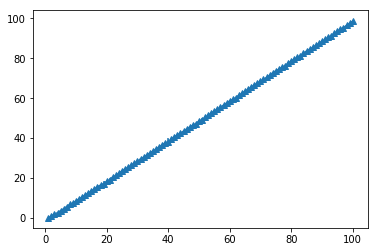

In [77]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'perceptron')
plot_sample_complexity(sample_complexity)

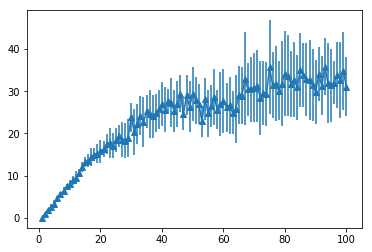

In [179]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'winnow') #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity)

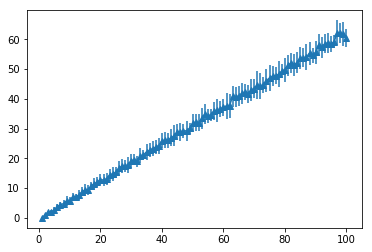

In [53]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'linear') #a bit slower, for some reason. 
plot_sample_complexity(sample_complexity)

In [ ]:
## Could potentially use Binary search method

In [ ]:
#m <= nplog(H_size/delta)/epsilon
#H_size restricted on S <= 2^m 

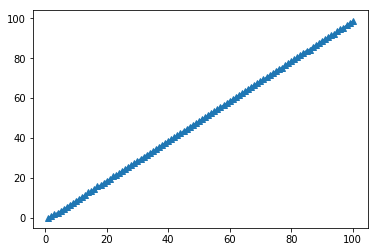

In [76]:
sample_complexity, iterations = estimate_sample_complexity(100,100,'1nn')
plot_sample_complexity(sample_complexity)